In [1]:
# This is a lab test from DataAnalisysWith PySpark
##<font size="12">Chapter 2</font>


In [2]:
# end-of-chapter.py############################################################
#
# Use this to get a free pass from Chapter 2 to Chapter 3.
#
# Remember, with great power comes great responsibility. Make sure you
# understand the code before running it! If necessary, refer to the text in
# Chapter 2.
#
###############################################################################

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, explode, lower, regexp_extract

spark = SparkSession.builder.getOrCreate()

book = spark.read.text("../data/gutenberg_books/1342-0.txt")

lines = book.select(split(book.value, " ").alias("line"))

words = lines.select(explode(col("line")).alias("word"))

words_lower = words.select(lower(col("word")).alias("word_lower"))

words_clean = words_lower.select(
    regexp_extract(col("word_lower"), "[a-z]*", 0).alias("word")
)

words_nonull = words_clean.where(col("word") != "")

In [3]:
#book = spark.read.text("../data/gutenberg_books/1342-0.txt")
#book
# DataFrame[value: string]

In [4]:
words_nonull.show(10)

+---------+
|     word|
+---------+
|    start|
|       of|
|      the|
|  project|
|gutenberg|
|    ebook|
|   george|
|    allen|
|publisher|
|  charing|
+---------+
only showing top 10 rows



In [5]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
# Import pathlib
from pathlib import Path

# Specify the file path
folder_path = Path("./results_single_partition.csv")

# Check if the file exists before deleting it
#if folder_path.exists():
    # Delete the file
#    folder_path.unlink()
#    print("File deleted successfully.")
#else:
#    print("File not found.")
    
# Removing a non-empty folder with shutil.rmtree()
import shutil

# Delete folder using shutil
try:
    shutil.rmtree(folder_path)
    print(f"The folder at {folder_path} has been successfully deleted!")
except OSError as e:
    print(f"Error: {folder_path} - {e.strerror}.")

spark = SparkSession.builder.appName(
    "Counting word occurences from a book."
).getOrCreate()

spark.sparkContext.setLogLevel("WARN")

#pyspark.sql.functions.explode
"""
    pyspark.sql.functions.explode(col: ColumnOrName) → pyspark.sql.column.Column[source]

    Returns a new row for each element in the given array or map. 
    Uses the default column name col for elements in the array and key and value for elements in the map unless specified otherwise.
    
"""

# If you need to read multiple text files, replace `1342-0` by `*`.
results = (
    spark.read.text("../data/gutenberg_books/1342-0.txt")
    .select(F.split(F.col("value"), " ").alias("line"))
    .select(F.explode(F.col("line")).alias("word"))
    .select(F.lower(F.col("word")).alias("word"))
    .select(F.regexp_extract(F.col("word"), "[a-z']*", 0).alias("word"))
    .where(F.col("word") != "")
    .groupby(F.col("word"))
    .count()
)

results.orderBy("count", ascending=False).show(10)
results.coalesce(1).write.csv("./results_single_partition.csv")

"""
When using toPandas(), remember that you lose the advantages of working with multiple machines, as the data will accumulate on the driver. 
Reserve this operation for an aggregated or manageable data set. While this is a crude formula, I usually take the number of rows times the number of columns; 
if this number is over 100,000 (for a 16 GB driver), I try to reduce it further. This simple trick helps me get a sense of the size of the data I am dealing with, 
as well as what’s possible given my driver size.

You do not want to move your data between a pandas and a PySpark data frame all the time. 
Reserve toPandas() for either discrete operations or for moving your data into a pandas data frame once and for all. 
Moving back and forth will yield a ton of unnecessary work in distributing and collecting the data for nothing.
"""
import os

if (os.path.exists("./results_single_partition_sg.csv")):
    os.remove("./results_single_partition_sg.csv")
    print("File deleted successfully.")
else:
    results.coalesce(1).toPandas().to_csv("./results_single_partition_sg.csv")

results.columns

The folder at results_single_partition.csv has been successfully deleted!
+----+-----+
|word|count|
+----+-----+
| the| 4617|
|  to| 4292|
|  of| 3831|
| and| 3615|
| her| 2254|
|   a| 2007|
|  in| 1964|
| was| 1867|
|   i| 1778|
| she| 1703|
+----+-----+
only showing top 10 rows

File deleted successfully.


['word', 'count']

In [6]:
from pyspark.sql.functions import col, split
lines = book.select(split(col("value"), " "))
lines

# DataFrame[split(value,  , -1): array<string>]
lines.printSchema()
# root
#  |-- split(value,  , -1): array (nullable = true)
#  |    |-- element: string (containsNull = true)
lines.show(5)
# +--------------------+
# | split(value,  , -1)|
# +--------------------+
# |[The, Project, Gu...|
# |                  []|
# |[This, eBook, is,...|
# |[almost, no, rest...|
# |[re-use, it, unde...|
# +--------------------+
# only showing top 5 rows

root
 |-- split(value,  , -1): array (nullable = true)
 |    |-- element: string (containsNull = false)

+--------------------+
| split(value,  , -1)|
+--------------------+
|[***, START, OF, ...|
|                  []|
|                  []|
|                  []|
|                  []|
+--------------------+
only showing top 5 rows



In [7]:
import io
DIRECTORY = "../data"
logs = spark.read.csv(
    os.path.join(DIRECTORY, "BroadcastLogs_2018_Q3_M8.CSV"),
    sep="|",
    header=True,
    inferSchema=True,
    timestampFormat="yyyy-MM-dd",
)


In [8]:
logs.printSchema()

root
 |-- BroadcastLogID: integer (nullable = true)
 |-- LogServiceID: integer (nullable = true)
 |-- LogDate: date (nullable = true)
 |-- SequenceNO: integer (nullable = true)
 |-- AudienceTargetAgeID: integer (nullable = true)
 |-- AudienceTargetEthnicID: integer (nullable = true)
 |-- CategoryID: integer (nullable = true)
 |-- ClosedCaptionID: integer (nullable = true)
 |-- CountryOfOriginID: integer (nullable = true)
 |-- DubDramaCreditID: integer (nullable = true)
 |-- EthnicProgramID: integer (nullable = true)
 |-- ProductionSourceID: integer (nullable = true)
 |-- ProgramClassID: integer (nullable = true)
 |-- FilmClassificationID: integer (nullable = true)
 |-- ExhibitionID: integer (nullable = true)
 |-- Duration: string (nullable = true)
 |-- EndTime: string (nullable = true)
 |-- LogEntryDate: date (nullable = true)
 |-- ProductionNO: string (nullable = true)
 |-- ProgramTitle: string (nullable = true)
 |-- StartTime: string (nullable = true)
 |-- Subtitle: string (nullable 

In [9]:
# Using the string to column conversion
logs.select("BroadCastLogID", "LogServiceID", "LogDate").show(10)
logs.select(*["BroadCastLogID", "LogServiceID", "LogDate"]).show(10)
 
# Passing the column object explicitly
logs.select(
    F.col("BroadCastLogID"), F.col("LogServiceID"), F.col("LogDate")
).show(10)
logs.select(
    *[F.col("BroadCastLogID"), F.col("LogServiceID"), F.col("LogDate")]
).show(10)

+--------------+------------+----------+
|BroadCastLogID|LogServiceID|   LogDate|
+--------------+------------+----------+
|    1196192316|        3157|2018-08-01|
|    1196192317|        3157|2018-08-01|
|    1196192318|        3157|2018-08-01|
|    1196192319|        3157|2018-08-01|
|    1196192320|        3157|2018-08-01|
|    1196192321|        3157|2018-08-01|
|    1196192322|        3157|2018-08-01|
|    1196192323|        3157|2018-08-01|
|    1196192324|        3157|2018-08-01|
|    1196192325|        3157|2018-08-01|
+--------------+------------+----------+
only showing top 10 rows

+--------------+------------+----------+
|BroadCastLogID|LogServiceID|   LogDate|
+--------------+------------+----------+
|    1196192316|        3157|2018-08-01|
|    1196192317|        3157|2018-08-01|
|    1196192318|        3157|2018-08-01|
|    1196192319|        3157|2018-08-01|
|    1196192320|        3157|2018-08-01|
|    1196192321|        3157|2018-08-01|
|    1196192322|        3157|20

In [10]:
logs.printSchema()

root
 |-- BroadcastLogID: integer (nullable = true)
 |-- LogServiceID: integer (nullable = true)
 |-- LogDate: date (nullable = true)
 |-- SequenceNO: integer (nullable = true)
 |-- AudienceTargetAgeID: integer (nullable = true)
 |-- AudienceTargetEthnicID: integer (nullable = true)
 |-- CategoryID: integer (nullable = true)
 |-- ClosedCaptionID: integer (nullable = true)
 |-- CountryOfOriginID: integer (nullable = true)
 |-- DubDramaCreditID: integer (nullable = true)
 |-- EthnicProgramID: integer (nullable = true)
 |-- ProductionSourceID: integer (nullable = true)
 |-- ProgramClassID: integer (nullable = true)
 |-- FilmClassificationID: integer (nullable = true)
 |-- ExhibitionID: integer (nullable = true)
 |-- Duration: string (nullable = true)
 |-- EndTime: string (nullable = true)
 |-- LogEntryDate: date (nullable = true)
 |-- ProductionNO: string (nullable = true)
 |-- ProgramTitle: string (nullable = true)
 |-- StartTime: string (nullable = true)
 |-- Subtitle: string (nullable 

In [11]:
import numpy as np
"""
The array_split() function comes from the numpy package, imported as np at the beginning of this listing.

Let’s take each line one at a time. We start by splitting the logs.columns list into approximate groups of three. 
To do so, we rely on a function from the numpy package called array_split(). 
The function takes an array and a number of desired sub-arrays, N, and returns a list of N sub-arrays. 
We wrap our list of columns, logs.columns, into an array via the np.array function and pass this as a first parameter. 
For the number of sub-arrays, we divide the number of columns by three, using an integer division, //.

"""

column_split = np.array_split(
    np.array(logs.columns), len(logs.columns) //3
)  
 
print(column_split)
 
# [array(['BroadcastLogID', 'LogServiceID', 'LogDate'], dtype='<U22'),
#  [...]
#  array(['Producer2', 'Language1', 'Language2'], dtype='<U22')]'
 
for x in column_split:
    logs.select(*x).show(5, False)
 
# +--------------+------------+-------------------+
# |BroadcastLogID|LogServiceID|LogDate            |
# +--------------+------------+-------------------+
# |1196192316    |3157        |2018-08-01 00:00:00|
# |1196192317    |3157        |2018-08-01 00:00:00|
# |1196192318    |3157        |2018-08-01 00:00:00|
# |1196192319    |3157        |2018-08-01 00:00:00|
# |1196192320    |3157        |2018-08-01 00:00:00|
# +--------------+------------+-------------------+
# only showing top 5 rows
# ... and more tables of three columns

[array(['BroadcastLogID', 'LogServiceID', 'LogDate'], dtype='<U22'), array(['SequenceNO', 'AudienceTargetAgeID', 'AudienceTargetEthnicID'],
      dtype='<U22'), array(['CategoryID', 'ClosedCaptionID', 'CountryOfOriginID'], dtype='<U22'), array(['DubDramaCreditID', 'EthnicProgramID', 'ProductionSourceID'],
      dtype='<U22'), array(['ProgramClassID', 'FilmClassificationID', 'ExhibitionID'],
      dtype='<U22'), array(['Duration', 'EndTime', 'LogEntryDate'], dtype='<U22'), array(['ProductionNO', 'ProgramTitle', 'StartTime'], dtype='<U22'), array(['Subtitle', 'NetworkAffiliationID', 'SpecialAttentionID'],
      dtype='<U22'), array(['BroadcastOriginPointID', 'CompositionID', 'Producer1'],
      dtype='<U22'), array(['Producer2', 'Language1', 'Language2'], dtype='<U22')]
+--------------+------------+----------+
|BroadcastLogID|LogServiceID|LogDate   |
+--------------+------------+----------+
|1196192316    |3157        |2018-08-01|
|1196192317    |3157        |2018-08-01|
|1196192318    |

In [12]:
logs = logs.drop("BroadcastLogID", "SequenceNO")
 
# Testing if we effectively got rid of the columns
 
print("BroadcastLogID" in logs.columns)  # => False
print("SequenceNo" in logs.columns)  # => False

False
False


In [13]:
logs = logs.select(
    *[x for x in logs.columns if x not in ["BroadcastLogID", "SequenceNO"]]
)

In [14]:
logs.columns[:]

['LogServiceID',
 'LogDate',
 'AudienceTargetAgeID',
 'AudienceTargetEthnicID',
 'CategoryID',
 'ClosedCaptionID',
 'CountryOfOriginID',
 'DubDramaCreditID',
 'EthnicProgramID',
 'ProductionSourceID',
 'ProgramClassID',
 'FilmClassificationID',
 'ExhibitionID',
 'Duration',
 'EndTime',
 'LogEntryDate',
 'ProductionNO',
 'ProgramTitle',
 'StartTime',
 'Subtitle',
 'NetworkAffiliationID',
 'SpecialAttentionID',
 'BroadcastOriginPointID',
 'CompositionID',
 'Producer1',
 'Producer2',
 'Language1',
 'Language2']

In [15]:
logs.select(
    F.col("CategoryID"),
    F.col("Duration"),
    F.col("Duration").substr(1, 2).cast("int").alias("dur_hours"),
    F.col("Duration").substr(4, 2).cast("int").alias("dur_minutes"),
    F.col("Duration").substr(7, 2).cast("int").alias("dur_seconds"),
).distinct().show(
    5
)
 
# +----------------+---------+-----------+-----------+
# |        Duration|dur_hours|dur_minutes|dur_seconds|
# +----------------+---------+-----------+-----------+
# |00:10:06.0000000|        0|         10|          6|
# |00:10:37.0000000|        0|         10|         37|
# |00:04:52.0000000|        0|          4|         52|
# |00:26:41.0000000|        0|         26|         41|
# |00:08:18.0000000|        0|          8|         18|
# +----------------+---------+-----------+-----------+
# only showing top 5 rows

logs.select(split(F.col("Duration"), " ").getItem(1)).show(5)

logs.select(
    F.col("CategoryID"),
    F.col("Duration"),
    split(F.col("Duration"), " ").getItem(1).substr(1, 2).cast("int").alias("dur_hours"),
    split(F.col("Duration"), " ").getItem(1).substr(4, 2).cast("int").alias("dur_minutes"),
    split(F.col("Duration"), " ").getItem(1).substr(7, 2).cast("int").alias("dur_seconds"),
).distinct().show(
    5
)

+----------+----------------+---------+-----------+-----------+
|CategoryID|        Duration|dur_hours|dur_minutes|dur_seconds|
+----------+----------------+---------+-----------+-----------+
|        11|00:59:47.0000000|        0|         59|         47|
|        11|00:45:05.0000000|        0|         45|          5|
|        11|00:40:37.0000000|        0|         40|         37|
|        11|00:32:48.0000000|        0|         32|         48|
|        11|00:19:44.0000000|        0|         19|         44|
+----------+----------------+---------+-----------+-----------+
only showing top 5 rows

+-------------------------+
|split(Duration,  , -1)[1]|
+-------------------------+
|                     NULL|
|                     NULL|
|                     NULL|
|                     NULL|
|                     NULL|
+-------------------------+
only showing top 5 rows

+----------+----------------+---------+-----------+-----------+
|CategoryID|        Duration|dur_hours|dur_minutes|dur_sec

In [37]:
logs.select(
    F.col("CategoryID"),
    F.col("ProgramClassID"),
    split(F.col("StartTime")," ").getItem(1).substr(1,2).alias("Time_Slot"),
    F.col("Duration"),
    (
        split(F.col("Duration"), " ").getItem(1).substr(1, 2).cast("int") * 60 * 60
        + split(F.col("Duration"), " ").getItem(1).substr(4, 2).cast("int") * 60
        + split(F.col("Duration"), " ").getItem(1).substr(7, 2).cast("int")
    ).alias("Duration_seconds"),
).distinct().show(5)
 
# +----------------+----------------+
# |        Duration|Duration_seconds|
# +----------------+----------------+
# |00:10:30.0000000|             630|
# |00:25:52.0000000|            1552|
# |00:28:08.0000000|            1688|
# |06:00:00.0000000|           21600|
# |00:32:08.0000000|            1928|
# +----------------+----------------+
# only showing top 5 rows

+----------+--------------+---------+-------------------+----------------+
|CategoryID|ProgramClassID|Time_Slot|           Duration|Duration_seconds|
+----------+--------------+---------+-------------------+----------------+
|        11|            19|       07|2024-11-11 01:00:01|            3601|
|        26|            20|       18|2024-11-11 00:00:15|              15|
|        11|            20|       20|2024-11-11 00:26:44|            1604|
|        11|            19|       21|2024-11-11 00:42:37|            2557|
|        11|            19|       00|2024-11-11 00:40:19|            2419|
+----------+--------------+---------+-------------------+----------------+
only showing top 5 rows



In [17]:
logs.toDF(*[x.lower() for x in logs.columns]).printSchema()

root
 |-- logserviceid: integer (nullable = true)
 |-- logdate: date (nullable = true)
 |-- audiencetargetageid: integer (nullable = true)
 |-- audiencetargetethnicid: integer (nullable = true)
 |-- categoryid: integer (nullable = true)
 |-- closedcaptionid: integer (nullable = true)
 |-- countryoforiginid: integer (nullable = true)
 |-- dubdramacreditid: integer (nullable = true)
 |-- ethnicprogramid: integer (nullable = true)
 |-- productionsourceid: integer (nullable = true)
 |-- programclassid: integer (nullable = true)
 |-- filmclassificationid: integer (nullable = true)
 |-- exhibitionid: integer (nullable = true)
 |-- duration: string (nullable = true)
 |-- endtime: string (nullable = true)
 |-- logentrydate: date (nullable = true)
 |-- productionno: string (nullable = true)
 |-- programtitle: string (nullable = true)
 |-- starttime: string (nullable = true)
 |-- subtitle: string (nullable = true)
 |-- networkaffiliationid: integer (nullable = true)
 |-- specialattentionid: inte

In [41]:
import os

import pyspark.sql.functions as F
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName(
    "Getting the Canadian TV channels with the highest/lowest proportion of commercials."
).getOrCreate()

spark.sparkContext.setLogLevel("WARN")

###############################################################################
# Reading all the relevant data sources
###############################################################################

DIRECTORY = "../data"

logs = spark.read.csv(
    os.path.join(DIRECTORY, "BroadcastLogs_2018_Q3_M8.CSV"),
    sep="|",
    header=True,
    inferSchema=True,
)

log_identifier = spark.read.csv(
    "../data/LogIdentifier.csv",
    sep="|",
    header=True,
    inferSchema=True,
)

cd_category = spark.read.csv(
    "../data/CD_Category.csv",
    sep="|",
    header=True,
    inferSchema=True,
).select(
    "CategoryID",
    "CategoryCD",
    F.col("EnglishDescription").alias("Category_Description"),
)

cd_category.show(5)

cd_program_class = spark.read.csv(
    "../data/CD_ProgramClass.csv",
    sep="|",
    header=True,
    inferSchema=True,
).select(
    "ProgramClassID",
    "ProgramClassCD",
    F.col("EnglishDescription").alias("ProgramClass_Description"),
)

cd_program_class.show(100)

###############################################################################
# Data processing
###############################################################################

logs = logs.drop("BroadcastLogID", "SequenceNO")

logs = logs.withColumn(
    "duration_seconds",
    (
        split(F.col("Duration"), " ").getItem(1).substr(1, 2).cast("int") * 60 * 60
        + split(F.col("Duration"), " ").getItem(1).substr(4, 2).cast("int") * 60
        + split(F.col("Duration"), " ").getItem(1).substr(7, 2).cast("int")
    ),
)

logs = logs.withColumn(
    "Time_Slot",
    (
        split(F.col("StartTime")," ").getItem(1).substr(1,2)
    ),
)
## PySpark joining types
## Join String 	- Equivalent SQL Join
## inner	    - INNER JOIN
## outer, full, fullouter, full_outer	FULL OUTER JOIN
## left, leftouter, left_outer	LEFT JOIN
## right, rightouter, right_outer	RIGHT JOIN
## cross	
## anti, leftanti, left_anti	
## semi, leftsemi, left_semi	

## reference url: https://sparkbyexamples.com/pyspark/pyspark-join-explained-with-examples/

log_identifier = log_identifier.where(F.col("PrimaryFG") == 1)

logs_and_channels = logs.join(log_identifier, "LogServiceID")

full_log = logs_and_channels.join(cd_category, "CategoryID", how="inner").join(
    cd_program_class, "ProgramClassID", how="inner"
)

full_log.groupby("LogIdentifierID").agg(
    F.sum(
        F.when(
            F.trim(F.col("ProgramClassCD")).isin(
                ["COM", "PRC", "PGI", "PRO", "LOC", "SPO", "MER", "SOL"]
            ),
            F.col("duration_seconds"),
        ).otherwise(0)
    ).alias("duration_commercial"),
    F.sum("duration_seconds").alias("duration_total"),
).withColumn(
    "commercial_ratio", F.col("duration_commercial") / F.col("duration_total")
).orderBy(
    "commercial_ratio", ascending=False
).show(
    100, False
)

+----------+----------+--------------------+
|CategoryID|CategoryCD|Category_Description|
+----------+----------+--------------------+
|         1|       010|                NEWS|
|         2|       02 |CANREC  ANALYSIS ...|
|         3|       02A|ANALYSIS AND INTE...|
|         4|       02B|LONG-FORM DOCUMEN...|
|         5|       030|REPORTING & ACTUA...|
+----------+----------+--------------------+
only showing top 5 rows

+--------------+--------------+------------------------+
|ProgramClassID|ProgramClassCD|ProgramClass_Description|
+--------------+--------------+------------------------+
|             1|          AUT |           AUTOPROMOTION|
|             2|          BAL |     BALANCE PROGRAMMING|
|             3|          COM |      COMMERCIAL MESSAGE|
|             4|          COR |             CORNERSTONE|
|             5|          DOC |             DOCUMENTARY|
|             6|          GIA |               GIVEAWAYS|
|             7|          ID  |    NETWORK IDENTIFIC...|


In [71]:
#from pyspark.sql import SparkSession
#from pyspark.sql.functions import col, avg, sum

# Initialize Spark session
#spark = SparkSession.builder.appName("BroadcastLogsAnalysis").getOrCreate()

# Load the data
#df = spark.read.option("header", "true").csv("../Data/BroadcastLogs_2018_Q3_M8.csv",sep="|")

#df = df.withColumn(
#    "duration_seconds",
#    (
#        F.col("Duration").substr(1, 2).cast("int") * 60 * 60
#        + F.col("Duration").substr(4, 2).cast("int") * 60
#        + F.col("Duration").substr(7, 2).cast("int")
#    ),
#)

fl = full_log.groupby("Time_Slot").agg(
    F.sum(
        F.when(
            F.trim(F.col("Time_Slot")).isin(
                ["COM", "PRC", "PGI", "PRO", "LOC", "SPO", "MER", "SOL"]
            ),
            F.col("duration_seconds"),
        ).otherwise(0)
    ).alias("duration_commercial"),
    F.sum("duration_seconds").alias("duration_total"),
    F.avg("duration_seconds").alias("duration_average"),
).withColumn(
    "commercial_ratio", F.col("duration_commercial") / F.col("duration_total")
).orderBy(
    "Time_Slot", ascending=True
)

fl.show(10)

cr = full_log.groupby("LogIdentifierID").agg(
    F.sum(
        F.when(
            F.trim(F.col("ProgramClassCD")).isin(
                ["COM", "PRC", "PGI", "PRO", "LOC", "SPO", "MER", "SOL"]
            ),
            F.col("duration_seconds"),
        ).otherwise(0)
    ).alias("duration_commercial"),
    F.sum("duration_seconds").alias("duration_total"),
).withColumn(
    "commercial_ratio", F.col("duration_commercial") / F.col("duration_total")
).orderBy(
    "commercial_ratio", ascending=False
)

cr.show(50)

+---------+-------------------+--------------+------------------+----------------+
|Time_Slot|duration_commercial|duration_total|  duration_average|commercial_ratio|
+---------+-------------------+--------------+------------------+----------------+
|       00|                  0|      34482388|1293.7040594282284|             0.0|
|       01|                  0|      30046436|1177.4604592836429|             0.0|
|       02|                  0|      30126928|1185.8660893524898|             0.0|
|       03|                  0|      30629525|1212.0904234269885|             0.0|
|       04|                  0|      29545781|1158.7035177850112|             0.0|
|       05|                  0|      28628071|1011.9501944149877|             0.0|
|       06|                  0|      39577277|1114.5389186144748|             0.0|
|       07|                  0|      30920042| 804.9369223960638|             0.0|
|       08|                  0|      28464138| 758.6188534420725|             0.0|
|   

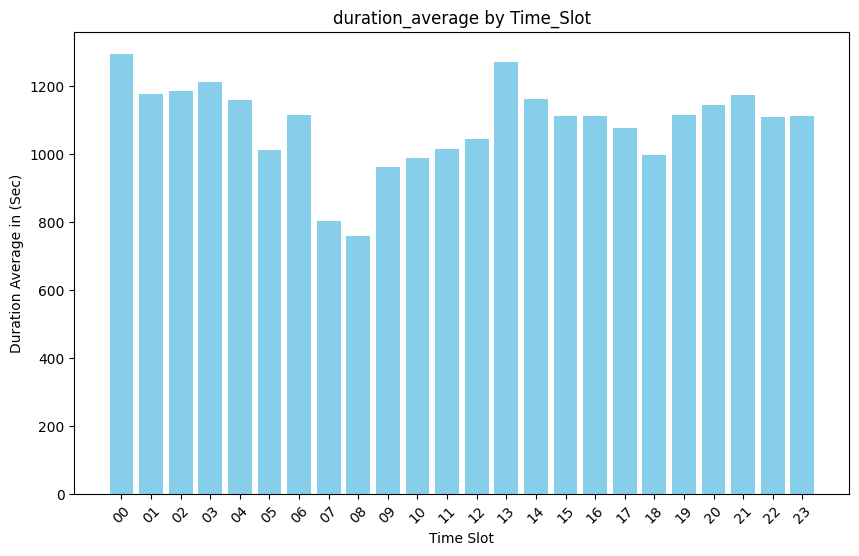

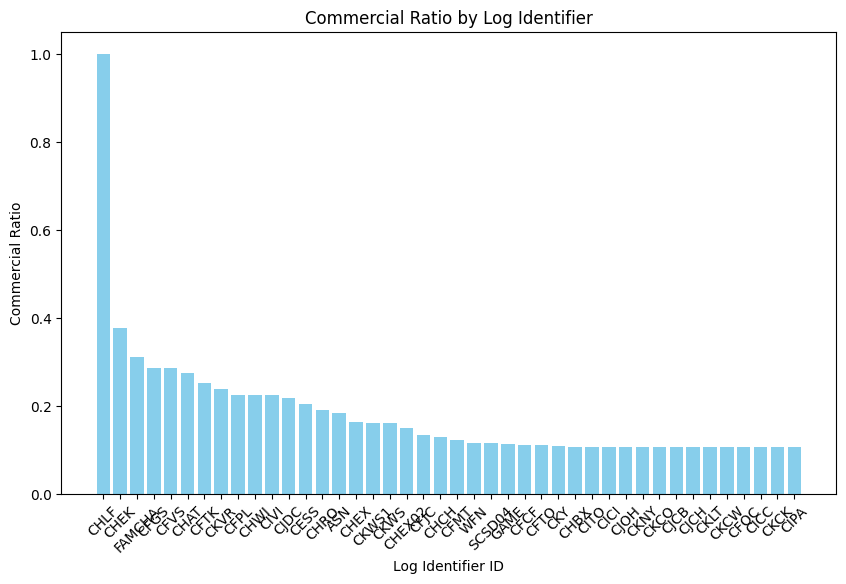

In [75]:
# If you have a timestamp column, you can analyze trends over time
# Example: df_clean = df_clean.withColumn("Month", month(col("Timestamp")))

# Visualization (using Pandas for simplicity)
import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame for visualization
pdf = fl.select("Time_Slot","commercial_ratio","duration_total","duration_average").toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(pdf["Time_Slot"], pdf["duration_average"], color='skyblue')
plt.xlabel("Time Slot")
plt.ylabel("Duration Average in (Sec)")
plt.title("duration_average by Time_Slot")
plt.xticks(rotation=45)
plt.show()

#Commercial Ratio > 0.1
pdf2 = cr.select("LogIdentifierID","duration_commercial","duration_total","commercial_ratio").filter(cr['commercial_ratio']>0.1).toPandas()

plt.figure(figsize=(10, 6))
plt.bar(pdf2["LogIdentifierID"], pdf2["commercial_ratio"], color='skyblue')
plt.xlabel("Log Identifier ID")
plt.ylabel("Commercial Ratio")
plt.title("Commercial Ratio by Log Identifier")
plt.xticks(rotation=45)
plt.show()